In [65]:
import pandas as pd
from datetime import datetime
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import math
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM, SimpleRNN, GRU

In [74]:
import plotly.io as pio
pio.renderers.default='notebook'

In [3]:
uber_apr14 = pd.read_csv('uber-tlc-foil-response-master/uber-trip-data/uber-raw-data-apr14.csv')

In [4]:
uber_apr14.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [11]:
uber_apr14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564516 entries, 0 to 564515
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date/Time  564516 non-null  object 
 1   Lat        564516 non-null  float64
 2   Lon        564516 non-null  float64
 3   Base       564516 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.2+ MB


In [5]:
uber_apr14['Date/Time'] = pd.to_datetime(uber_apr14['Date/Time'])

In [6]:
df = uber_apr14.groupby([pd.Grouper(key='Date/Time',freq='H')]).size().reset_index(name='count')
fig = px.line(df, x='Date/Time', y="count")
fig.show()


In [9]:
df_by_base = uber_apr14.groupby([pd.Grouper(key='Date/Time',freq='H'),uber_apr14.Base]).size().reset_index(name='count')
fig = px.bar(df_by_base[:700], x='Date/Time', y="count", color='Base')
fig.show()


In [10]:
print(df)

              Date/Time  count
0   2014-04-01 00:00:00    138
1   2014-04-01 01:00:00     66
2   2014-04-01 02:00:00     53
3   2014-04-01 03:00:00     93
4   2014-04-01 04:00:00    166
..                  ...    ...
715 2014-04-30 19:00:00   2834
716 2014-04-30 20:00:00   2766
717 2014-04-30 21:00:00   2308
718 2014-04-30 22:00:00   1778
719 2014-04-30 23:00:00    895

[720 rows x 2 columns]


In [11]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
df = min_max_scaler.fit_transform(df['count'].values.reshape(-1, 1))
df[:5]

array([[0.0310725 ],
       [0.00701637],
       [0.0026729 ],
       [0.01603742],
       [0.04042766]])

In [12]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:len(df)]
print(len(train), len(test))

576 144


In [13]:
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

x_train, y_train = create_dataset(train, look_back=15)
x_test, y_test = create_dataset(test, look_back=15)

In [14]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [16]:
look_back = 15
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
560/560 - 3s - loss: 0.0152
Epoch 2/20
560/560 - 2s - loss: 0.0055
Epoch 3/20
560/560 - 2s - loss: 0.0046
Epoch 4/20
560/560 - 2s - loss: 0.0040
Epoch 5/20
560/560 - 2s - loss: 0.0036
Epoch 6/20
560/560 - 2s - loss: 0.0035
Epoch 7/20
560/560 - 2s - loss: 0.0032
Epoch 8/20
560/560 - 2s - loss: 0.0031
Epoch 9/20
560/560 - 2s - loss: 0.0030
Epoch 10/20
560/560 - 2s - loss: 0.0029
Epoch 11/20
560/560 - 2s - loss: 0.0029
Epoch 12/20
560/560 - 2s - loss: 0.0027
Epoch 13/20
560/560 - 2s - loss: 0.0028
Epoch 14/20
560/560 - 2s - loss: 0.0027
Epoch 15/20
560/560 - 2s - loss: 0.0027
Epoch 16/20
560/560 - 2s - loss: 0.0026
Epoch 17/20
560/560 - 2s - loss: 0.0027
Epoch 18/20
560/560 - 2s - loss: 0.0026
Epoch 19/20
560/560 - 2s - loss: 0.0025
Epoch 20/20
560/560 - 3s - loss: 0.0024


In [17]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 145.58 RMSE
Test Score: 191.57 RMSE


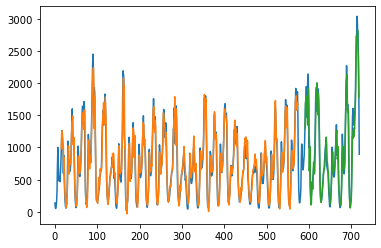

In [23]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict
# plot baseline and predictions
plt.plot(min_max_scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [33]:
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

### LSTM layer

In [1]:
df_b02512 = df_by_base[df_by_base['Base']=='B02512'].drop(axis=0, columns='Base')
df_b02598 = df_by_base[df_by_base['Base']=='B02598'].drop(axis=0, columns='Base')
df_b02617 = df_by_base[df_by_base['Base']=='B02617'].drop(axis=0, columns='Base')
df_b02682 = df_by_base[df_by_base['Base']=='B02682'].drop(axis=0, columns='Base')
df_b02764 = df_by_base[df_by_base['Base']=='B02764'].drop(axis=0, columns='Base')

for df, base in zip([df_b02512, df_b02598, df_b02617, df_b02682, df_b02764],['B02512', 'B02598', 'B02617', 'B02682', 'B02764']):
    
    df_for_graph = df.reset_index(drop=True)
    
    print(base)
    
    min_max_scaler = MinMaxScaler(feature_range=(0, 1))
    df = min_max_scaler.fit_transform(df['count'].values.reshape(-1, 1))

    train_size = int(len(df) * 0.8)
    test_size = len(df) - train_size
    train, test = df[0:train_size], df[train_size:len(df)]

    x_train, y_train = create_dataset(train, look_back=15)
    x_test, y_test = create_dataset(test, look_back=15)

    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    
    look_back = 15
    model = Sequential()
    model.add(LSTM(20, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=0)

    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)
    
    # invert predictions
    trainPredict = min_max_scaler.inverse_transform(trainPredict)
    trainY = min_max_scaler.inverse_transform([y_train])
    testPredict = min_max_scaler.inverse_transform(testPredict)
    testY = min_max_scaler.inverse_transform([y_test])

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))

    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(df)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(df)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict

    # plot baseline and predictions

    df_for_graph['trainPredictPlot'] = trainPredictPlot
    df_for_graph['testPredictPlot'] = testPredictPlot

    fig = px.line(df_for_graph, x='Date/Time', y=df_for_graph.columns[1:4], title=base)
    fig.show()

NameError: name 'df_by_base' is not defined

### Simple RNN layer

In [2]:
df_b02512 = df_by_base[df_by_base['Base']=='B02512'].drop(axis=0, columns='Base')
df_b02598 = df_by_base[df_by_base['Base']=='B02598'].drop(axis=0, columns='Base')
df_b02617 = df_by_base[df_by_base['Base']=='B02617'].drop(axis=0, columns='Base')
df_b02682 = df_by_base[df_by_base['Base']=='B02682'].drop(axis=0, columns='Base')
df_b02764 = df_by_base[df_by_base['Base']=='B02764'].drop(axis=0, columns='Base')

for df, base in zip([df_b02512, df_b02598, df_b02617, df_b02682, df_b02764],['B02512', 'B02598', 'B02617', 'B02682', 'B02764']):
    
    df_for_graph = df.reset_index(drop=True)
    
    print(base)
    
    min_max_scaler = MinMaxScaler(feature_range=(0, 1))
    df = min_max_scaler.fit_transform(df['count'].values.reshape(-1, 1))

    train_size = int(len(df) * 0.8)
    test_size = len(df) - train_size
    train, test = df[0:train_size], df[train_size:len(df)]

    x_train, y_train = create_dataset(train, look_back=15)
    x_test, y_test = create_dataset(test, look_back=15)

    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    
    look_back = 15
    model = Sequential()
    model.add(SimpleRNN(20, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=0)

    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)
    
    # invert predictions
    trainPredict = min_max_scaler.inverse_transform(trainPredict)
    trainY = min_max_scaler.inverse_transform([y_train])
    testPredict = min_max_scaler.inverse_transform(testPredict)
    testY = min_max_scaler.inverse_transform([y_test])

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))

    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(df)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(df)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict

    # plot baseline and predictions

    df_for_graph['trainPredictPlot'] = trainPredictPlot
    df_for_graph['testPredictPlot'] = testPredictPlot

    fig = px.line(df_for_graph, x='Date/Time', y=df_for_graph.columns[1:4], title=base)
    fig.show()

NameError: name 'df_by_base' is not defined

### Dense layer (basic deep learning)

In [3]:
df_b02512 = df_by_base[df_by_base['Base']=='B02512'].drop(axis=0, columns='Base')
df_b02598 = df_by_base[df_by_base['Base']=='B02598'].drop(axis=0, columns='Base')
df_b02617 = df_by_base[df_by_base['Base']=='B02617'].drop(axis=0, columns='Base')
df_b02682 = df_by_base[df_by_base['Base']=='B02682'].drop(axis=0, columns='Base')
df_b02764 = df_by_base[df_by_base['Base']=='B02764'].drop(axis=0, columns='Base')

for df, base in zip([df_b02512, df_b02598, df_b02617, df_b02682, df_b02764],['B02512', 'B02598', 'B02617', 'B02682', 'B02764']):
    
    df_for_graph = df.reset_index(drop=True)
    
    print(base)
    
    min_max_scaler = MinMaxScaler(feature_range=(0, 1))
    df = min_max_scaler.fit_transform(df['count'].values.reshape(-1, 1))

    train_size = int(len(df) * 0.8)
    test_size = len(df) - train_size
    train, test = df[0:train_size], df[train_size:len(df)]

    x_train, y_train = create_dataset(train, look_back=15)
    x_test, y_test = create_dataset(test, look_back=15)

    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    
    look_back = 15
    model = Sequential()
    model.add(Dense(20, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=0)

    trainPredict = np.squeeze(model.predict(x_train), axis=(2,))
    testPredict = np.squeeze(model.predict(x_test), axis=(2,))

    # invert predictions
    trainPredict = min_max_scaler.inverse_transform(trainPredict)
    trainY = min_max_scaler.inverse_transform([y_train])
    testPredict = min_max_scaler.inverse_transform(testPredict)
    testY = min_max_scaler.inverse_transform([y_test])

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))

    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(df)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(df)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict

    # plot baseline and predictions

    df_for_graph['trainPredictPlot'] = trainPredictPlot
    df_for_graph['testPredictPlot'] = testPredictPlot

    fig = px.line(df_for_graph, x='Date/Time', y=df_for_graph.columns[1:4], title=base)
    fig.show()

NameError: name 'df_by_base' is not defined

(558, 1)